## Phising Dataset

To collect the dataset, we have deployed multiple agents and soluble agents within an infrastructure with
more than 3k entities, comprising laptops, workstations, and smartphone devices. <br> The methods to build
ground truth are as follows:

- Simulator: We launch different realistic phishing campaigns, aiming to expose user credentials or defeat access to a service.
- IDS: We deploy an IDS to collect various alerts associated with behavioral anomalies, such as cryptomining or peer-to-peer traffic.

For each user exposed to the behaviors stated in the summary table, different TW is computed, aggregating
user behavior within a fixed time interval. <br> This TW serves as the basis for generating various supervised
and unsupervised methods.

In [1]:
import pickle

## Time window representation 

The time windows (TW) are a data representation based on aggregated logs from multimodal sources between two
timestamps. <br> In this study, logs from HTTP, DNS, SSL, and SMTP are taken into consideration, allowing the
construction of rich behavioral profiles. <br> The indicators described in the TE are a set of manually curated
interpretable features designed to describe device-level properties within the specified time frame.

In [2]:
import pandas as pd
import xgboost as xgb
from sklearn.pipeline import Pipeline
from sklearn.preprocessing import StandardScaler,RobustScaler,MinMaxScaler
from modules.lib import *

In [22]:
data = pd.read_parquet('metadata/datasets/Phishing_desktop.parquet')

In [19]:
data.drop(columns=['user_id','entity','timestamp'], inplace=True)

In [21]:
data.to_parquet('metadata/datasets/Phishing_desktop.parquet', index=False)

In [3]:
entity = "desktop" #desktop or smartphone
threat = "phishing_behaviour" 
path_dataset = f'data/Risky Behaviour Datasets/{threat}/min_windows_size_6/{entity}_features.pckl'
seed = 42


dataset = pd.read_pickle(path_dataset)

#### Load and split dataset based on the unique users

In [6]:
data = dataset[dataset['user_id'].isin(unique_users)].reset_index(drop=True)

In [7]:
train_index = data[data['user_id'].isin(users_train_test)].index.tolist()

In [8]:
test_index = data[data['user_id'].isin(users_validation)].index.tolist()

In [5]:
from sklearn.model_selection import train_test_split



unique_users = dataset.loc[dataset["label"] != -1, 'user_id'].unique()

# Split user IDs into train_test and validation sets
# We fix validation dataset to be always the same by fixing the random state, the rest changes
users_train_test, users_validation = train_test_split(unique_users, test_size=0.3, random_state=seed)

data_train_test = dataset[dataset['user_id'].isin(users_train_test)]
data_validation_labeled = dataset[dataset['user_id'].isin(users_validation)]


In [43]:
data_train_test = data_train_test.drop(columns=["timestamp", "user_id", "entity"])

### Model creation and Training

In [44]:
import numpy as np
cat_columns = data_train_test.select_dtypes(exclude=[np.number]).columns.tolist()
numeric_columns = data_train_test.drop(columns='label').select_dtypes(exclude=['object']).columns.tolist()

In [45]:
import os
import itertools
from tensorflow.keras.models import clone_model
import numpy as np
from classes.multiclass_models import NeuralNetwork


# Parameter grid
param_grid = {
    'batch_size': [16, 32],
    'epochs': [2, 10],
}

# Mock dataset for training (replace with real dataset
         # Example labels (categorical)

# Convert labels to one-hot encoding

# Create directory to store models
output_dir = "metadata/proxy_data_models"
os.makedirs(output_dir, exist_ok=True)
#n_timestamps = data_train_test.drop(columns='label').shape[0]
n_features = data_train_test.drop(columns='label').shape[1]
# Generate all parameter combinations
keys, values = zip(*param_grid.items())
param_combinations = [dict(zip(keys, v)) for v in itertools.product(*values)]
model_nn = NeuralNetwork(n_features, 'relu', [100,100,100],n_classes=1)
model_nn.create_model()



# Iterate over parameter combinations
for i, params in enumerate(param_combinations):
    print(f"Training model {i+1} with parameters: {params}")
    
    # Extract model-specific parameters
    # units = params['model__units']
    # activation_function = params['model__activation_function']
    batch_size = params['batch_size']
    epochs = params['epochs']
    
    # Create the model
    # model = create_model(n_timestamps, n_features, activation_function=activation_function, units=units, n_classes=n_classes)
    
    # Train the model
    early_stopping = model_nn.early_stopping_callback()
    callback_list = [early_stopping]


    model_nn.model_compilation(model_nn.model)


    history_nn = model_nn.model_fitting(model_nn.model, data_train_test.drop(columns='label'), data_train_test['label'], data_validation_labeled.drop(columns=['user_id','timestamp','label','entity']), data_validation_labeled['label'], callback_list, epochs, batch_size)

    # Define a unique path for saving the model
    # model_name = f"Ideko_workflow_{i+1}.keras"
    # # model_filename = os.path.join(output_dir, model_name)
    # # model_path = os.path.join(output_dir, model_name)
    
    # # Save the model
    # # os.makedirs(os.path.dirname(model_filename), exist_ok=True)
    model_nn.model.save('trained_model')
    # print(f"Model {i+1} saved to {model_name}")

print(f"Trained and saved {len(param_combinations)} models.")


2025-03-18 16:06:26,442 - classes.multiclass_models - INFO - create_model(): Create model NEURAL NETWORK with 3 layers


KeyboardInterrupt: 

In [ ]:
from sklearn.model_selection import GridSearchCV
from tensorflow.keras.models import Sequential
from tensorflow.keras.layers import Dense
from tensorflow.keras.layers import Dropout
from scikeras.wrappers import KerasClassifier
from keras.layers import Masking, Dense, Flatten, Conv1D, MaxPooling1D, SimpleRNN, LSTM
from keras import Input

def create_model(n_timestamps, n_features, activation_function='relu', units=(50, 50,50), n_classes=2):
    model = Sequential()
    # Input layer
    model.add(Input(shape=(n_features,)))
    # Masking layer
    model.add(Masking(mask_value=0))
    # Fully connected layers
    for unit in units:
        model.add(Dense(units=unit, activation=activation_function))
    # Flatten layer
    model.add(Flatten())
    # Output layer
    model.add(Dense(1, activation="sigmoid"))
    
    model.compile(optimizer='adam', loss='binary_crossentropy', metrics=['accuracy'])
    return model

n_timestamps = data_train_test.drop(columns='label').shape[0]
n_features = data_train_test.drop(columns='label').shape[1]

model = create_model(n_timestamps=n_timestamps, n_features=n_features, activation_function='relu', units=[100, 100, 100], n_classes=2)
    
model.fit(data_train_test.drop(columns='label'), data_train_test.label, 
              batch_size=16, 
              epochs=2)

# print(model.predict(data_validation_labeled.drop(columns='label')))
# tf.saved_model.save(model, "my_model")
model.save('trained_model')
# import tensorflow as tf
# predicted = tf.squeeze(model.predict(data_validation_labeled.drop(columns='label')))
# predicted = np.array([1 if x >= 0.5 else 0 for x in predicted])


Epoch 1/2
336/336 ━━━━━━━━━━━━━━━━━━━━ 0s 457us/step - accuracy: 0.5796 - loss: 378.7507
Epoch 2/2
336/336 ━━━━━━━━━━━━━━━━━━━━ 0s 399us/step - accuracy: 0.6219 - loss: 92.0826


ValueError: Invalid filepath extension for saving. Please add either a `.keras` extension for the native Keras format (recommended) or a `.h5` extension. Use `model.export(filepath)` if you want to export a SavedModel for use with TFLite/TFServing/etc. Received: filepath=trained_model.

In [ ]:
loaded_model = tf.saved_model.load("my_model")
infer = loaded_model.signatures["serving_default"]


In [ ]:
input_data = data_validation_labeled.drop(columns='label').values.astype(np.float32)
input_tensor = tf.constant(input_data)
input_tensor


<tf.Tensor: shape=(2805, 81), dtype=float32, numpy=
array([[18.        ,  0.        ,  0.        , ...,  0.16666667,
         0.16666667,  0.16666667],
       [22.        ,  0.        ,  0.        , ...,  0.33333334,
         0.33333334,  0.33333334],
       [22.        ,  0.        ,  0.        , ...,  0.33333334,
         0.33333334,  0.33333334],
       ...,
       [31.        ,  0.        ,  0.        , ...,  0.        ,
         0.        ,  0.        ],
       [38.        ,  0.        ,  0.        , ...,  0.        ,
         0.        ,  0.        ],
       [ 7.        ,  0.        ,  0.        , ...,  0.        ,
         0.        ,  0.        ]], dtype=float32)>

In [ ]:
output = infer(input_tensor)


In [ ]:
predictions = output["output_0"].numpy()
predictions

array([[1.       ],
       [1.       ],
       [0.9999993],
       ...,
       [0.9995625],
       [0.9821758],
       [0.2084233]], dtype=float32)

In [ ]:
infer(data_validation_labeled.drop(columns='label'))

TypeError: Binding inputs to tf.function failed due to `too many positional arguments`. Received args: (    dns_interlog_time_q1  dns_interlog_time_q2  dns_interlog_time_q3  \
0                   18.0                   0.0                   0.0   
0                   22.0                   0.0                   0.0   
0                   22.0                   0.0                   0.0   
0                   22.0                   0.0                   0.0   
0                    4.0                   0.0                   0.0   
..                   ...                   ...                   ...   
0                    0.0                   0.0                   0.0   
0                    0.0                   0.0                   0.0   
0                   31.0                   0.0                   0.0   
0                   38.0                   0.0                   0.0   
0                    7.0                   0.0                   0.0   

    dns_interlog_time_q4  dns_interlog_time_q5  ssl_interlog_time_q1  \
0                    0.0                   0.0                  10.0   
0                    0.0                   0.0                  40.0   
0                    0.0                   0.0                  61.0   
0                    0.0                   0.0                 137.0   
0                    0.0                   0.0                 127.0   
..                   ...                   ...                   ...   
0                    0.0                   0.0                  12.0   
0                    0.0                   0.0                  12.0   
0                    0.0                   0.0                  24.0   
0                    0.0                   0.0                  56.0   
0                    0.0                   0.0                  32.0   

    ssl_interlog_time_q2  ssl_interlog_time_q3  ssl_interlog_time_q4  \
0                    0.0                   0.0                   0.0   
0                    0.0                   0.0                   0.0   
0                    1.0                   0.0                   0.0   
0                    1.0                   0.0                   0.0   
0                    1.0                   0.0                   0.0   
..                   ...                   ...                   ...   
0                    0.0                   0.0                   0.0   
0                    0.0                   0.0                   0.0   
0                    1.0                   0.0                   0.0   
0                    1.0                   0.0                   0.0   
0                    0.0                   0.0                   0.0   

    ssl_interlog_time_q5  ...  smtp_in_is_normal  smtp_in_is_spam  \
0                    0.0  ...                0.0              0.0   
0                    0.0  ...                0.0              0.0   
0                    0.0  ...                0.0              0.0   
0                    0.0  ...                0.0              0.0   
0                    0.0  ...                0.0              0.0   
..                   ...  ...                ...              ...   
0                    0.0  ...                1.0              0.0   
0                    0.0  ...                0.0              0.0   
0                    0.0  ...                0.0              0.0   
0                    0.0  ...                0.0              0.0   
0                    0.0  ...                0.0              0.0   

    smtp_in_files  smtp_in_hazardous_extensions  non_working_days_dns  \
0             0.0                           0.0                   0.0   
0             0.0                           0.0                   0.0   
0             0.0                           0.0                   0.0   
0             0.0                           0.0                   0.0   
0             0.0                           0.0                   0.0   
..            ...                           ...                   ...   
0             0.0                           0.0                   0.0   
0             0.0                           0.0                   0.0   
0             0.0                           0.0                   0.0   
0             0.0                           0.0                   0.0   
0             0.0                           0.0                   0.0   

    non_working_days_http  non_working_days_ssl  non_working_hours_dns  \
0                     0.0                   0.0               0.166667   
0                     0.0                   0.0               0.333333   
0                     0.0                   0.0               0.333333   
0                     0.0                   0.0               0.333333   
0                     0.0                   0.0               0.166667   
..                    ...                   ...                    ...   
0                     0.0                   0.0               0.000000   
0                     0.0                   0.0               0.000000   
0                     0.0                   0.0               0.000000   
0                     0.0                   0.0               0.000000   
0                     0.0                   0.0               0.000000   

    non_working_hours_http  non_working_hours_ssl  
0                 0.166667               0.166667  
0                 0.333333               0.333333  
0                 0.333333               0.333333  
0                 0.333333               0.333333  
0                 0.166667               0.166667  
..                     ...                    ...  
0                 0.000000               0.000000  
0                 0.000000               0.000000  
0                 0.000000               0.000000  
0                 0.000000               0.000000  
0                 0.000000               0.000000  

[2805 rows x 81 columns],) and kwargs: {} for signature: (*, inputs: TensorSpec(shape=(None, 81), dtype=tf.float32, name='inputs')) -> Dict[['output_0', TensorSpec(shape=(None, 1), dtype=tf.float32, name='output_0')]].
Fallback to flat signature also failed due to: signature_wrapper_serving_default(inputs): expected argument #0(zero-based) to be a Tensor; got DataFrame (    dns_interlog_time_q1  dns_interlog_time_q2  dns_interlog_time_q3  \
0                   18.0                   0.0                   0.0   
0                   22.0                   0.0                   0.0   
0                   22.0                   0.0                   0.0   
0                   22.0                   0.0                   0.0   
0                    4.0                   0.0                   0.0   
..                   ...                   ...                   ...   
0                    0.0                   0.0                   0.0   
0                    0.0                   0.0                   0.0   
0                   31.0                   0.0                   0.0   
0                   38.0                   0.0                   0.0   
0                    7.0                   0.0                   0.0   

    dns_interlog_time_q4  dns_interlog_time_q5  ssl_interlog_time_q1  \
0                    0.0                   0.0                  10.0   
0                    0.0                   0.0                  40.0   
0                    0.0                   0.0                  61.0   
0                    0.0                   0.0                 137.0   
0                    0.0                   0.0                 127.0   
..                   ...                   ...                   ...   
0                    0.0                   0.0                  12.0   
0                    0.0                   0.0                  12.0   
0                    0.0                   0.0                  24.0   
0                    0.0                   0.0                  56.0   
0                    0.0                   0.0                  32.0   

    ssl_interlog_time_q2  ssl_interlog_time_q3  ssl_interlog_time_q4  \
0                    0.0                   0.0                   0.0   
0                    0.0                   0.0                   0.0   
0                    1.0                   0.0                   0.0   
0                    1.0                   0.0                   0.0   
0                    1.0                   0.0                   0.0   
..                   ...                   ...                   ...   
0                    0.0                   0.0                   0.0   
0                    0.0                   0.0                   0.0   
0                    1.0                   0.0                   0.0   
0                    1.0                   0.0                   0.0   
0                    0.0                   0.0                   0.0   

    ssl_interlog_time_q5  ...  smtp_in_is_normal  smtp_in_is_spam  \
0                    0.0  ...                0.0              0.0   
0                    0.0  ...                0.0              0.0   
0                    0.0  ...                0.0              0.0   
0                    0.0  ...                0.0              0.0   
0                    0.0  ...                0.0              0.0   
..                   ...  ...                ...              ...   
0                    0.0  ...                1.0              0.0   
0                    0.0  ...                0.0              0.0   
0                    0.0  ...                0.0              0.0   
0                    0.0  ...                0.0              0.0   
0                    0.0  ...                0.0              0.0   

    smtp_in_files  smtp_in_hazardous_extensions  non_working_days_dns  \
0             0.0                           0.0                   0.0   
0             0.0                           0.0                   0.0   
0             0.0                           0.0                   0.0   
0             0.0                           0.0                   0.0   
0             0.0                           0.0                   0.0   
..            ...                           ...                   ...   
0             0.0                           0.0                   0.0   
0             0.0                           0.0                   0.0   
0             0.0                           0.0                   0.0   
0             0.0                           0.0                   0.0   
0             0.0                           0.0                   0.0   

    non_working_days_http  non_working_days_ssl  non_working_hours_dns  \
0                     0.0                   0.0               0.166667   
0                     0.0                   0.0               0.333333   
0                     0.0                   0.0               0.333333   
0                     0.0                   0.0               0.333333   
0                     0.0                   0.0               0.166667   
..                    ...                   ...                    ...   
0                     0.0                   0.0               0.000000   
0                     0.0                   0.0               0.000000   
0                     0.0                   0.0               0.000000   
0                     0.0                   0.0               0.000000   
0                     0.0                   0.0               0.000000   

    non_working_hours_http  non_working_hours_ssl  
0                 0.166667               0.166667  
0                 0.333333               0.333333  
0                 0.333333               0.333333  
0                 0.333333               0.333333  
0                 0.166667               0.166667  
..                     ...                    ...  
0                 0.000000               0.000000  
0                 0.000000               0.000000  
0                 0.000000               0.000000  
0                 0.000000               0.000000  
0                 0.000000               0.000000  

[2805 rows x 81 columns]).

In [ ]:
import torch
import torch.nn as nn
import torch.optim as optim
from torch.utils.data import DataLoader, TensorDataset
import itertools
import os

# Parameter grid
param_grid = {
    'batch_size': [16, 32],
    'epochs': [2, 10],
}

param_combinations = list(itertools.product(*param_grid.values()))

class MLPModel(nn.Module):
    def __init__(self, n_features, units=(100, 100, 100)):
        super(MLPModel, self).__init__()
        layers = []
        layers.append(nn.Linear(n_features, units[0]))
        layers.append(nn.ReLU())
        for i in range(len(units) - 1):
            layers.append(nn.Linear(units[i], units[i + 1]))
            layers.append(nn.ReLU())
        layers.append(nn.Linear(units[-1], 1))
        layers.append(nn.Sigmoid())
        self.model = nn.Sequential(*layers)
    
    def forward(self, x):
        return self.model(x)

# Convert data to PyTorch tensors
X_train = torch.tensor(data_train_test.drop(columns='label').values, dtype=torch.float32)
y_train = torch.tensor(data_train_test.label.values, dtype=torch.float32).view(-1, 1)
X_val = torch.tensor(data_validation_labeled.drop(columns=['user_id','timestamp','label']).values, dtype=torch.float32)

# Iterate over parameter combinations
for i, params in enumerate(param_combinations):
    print(f"Training model {i+1} with parameters: {params}")
    batch_size, epochs = params
    
    dataset = TensorDataset(X_train, y_train)
    dataloader = DataLoader(dataset, batch_size=batch_size, shuffle=True)
    
    model = MLPModel(n_features=X_train.shape[1])
    criterion = nn.BCELoss()
    optimizer = optim.Adam(model.parameters(), lr=0.001)
    
    # Training loop
    for epoch in range(epochs):
        for batch_X, batch_y in dataloader:
            optimizer.zero_grad()
            outputs = model(batch_X)
            loss = criterion(outputs, batch_y)
            loss.backward()
            optimizer.step()
        print(f"Model {i+1} - Epoch {epoch+1}, Loss: {loss.item():.4f}")
    
    # Save model
    model_name = f"I2Cat_torchmodel_{i+1}.pth"
    torch.save(model, model_name)
    print(f"Model {i+1} saved to {model_name}")

print(f"Trained and saved {len(param_combinations)} models.")


Training model 1 with parameters: (16, 2)
Model 1 - Epoch 1, Loss: 15.5132
Model 1 - Epoch 2, Loss: 36.5912
Model 1 saved to I2Cat_torchmodel_1.pth
Training model 2 with parameters: (16, 10)
Model 2 - Epoch 1, Loss: 18.9214
Model 2 - Epoch 2, Loss: 12.3913
Model 2 - Epoch 3, Loss: 18.4340
Model 2 - Epoch 4, Loss: 36.6440
Model 2 - Epoch 5, Loss: 0.2259
Model 2 - Epoch 6, Loss: 10.7530
Model 2 - Epoch 7, Loss: 1.9551
Model 2 - Epoch 8, Loss: 6.8660
Model 2 - Epoch 9, Loss: 28.6200
Model 2 - Epoch 10, Loss: 0.4318
Model 2 saved to I2Cat_torchmodel_2.pth
Training model 3 with parameters: (32, 2)
Model 3 - Epoch 1, Loss: 8.9904
Model 3 - Epoch 2, Loss: 6.9853
Model 3 saved to I2Cat_torchmodel_3.pth
Training model 4 with parameters: (32, 10)
Model 4 - Epoch 1, Loss: 2.3360
Model 4 - Epoch 2, Loss: 3.4171
Model 4 - Epoch 3, Loss: 1.1460
Model 4 - Epoch 4, Loss: 3.7216
Model 4 - Epoch 5, Loss: 0.5488
Model 4 - Epoch 6, Loss: 0.5343
Model 4 - Epoch 7, Loss: 0.5758
Model 4 - Epoch 8, Loss: 0.54

In [ ]:
import torch
import torch.nn as nn
import torch.optim as optim
from torch.utils.data import DataLoader, TensorDataset
import itertools
import os
model = torch.load("I2Cat_torchmodel_1.pth")

AttributeError: Can't get attribute 'MLPModel' on <module '__main__'>

In [ ]:
import keras
model = tf.keras.models.load_model("metadata/proxy_data_models/I2Cat_nn.keras")

In [ ]:
model.predict(data_validation_labeled.drop(columns='label'))

88/88 ━━━━━━━━━━━━━━━━━━━━ 0s 486us/step


array([[0.05629352],
       [0.07750648],
       [0.07115746],
       ...,
       [0.11501791],
       [0.03180849],
       [0.33416763]], dtype=float32)

In [ ]:
predicted_class = (model(X_val) >= 0.5).float()


In [ ]:
torch.sigmoid(model(X_val))

tensor([[0.7172],
        [0.7061],
        [0.6790],
        ...,
        [0.6575],
        [0.6133],
        [0.5625]], grad_fn=<SigmoidBackward0>)

In [ ]:
numerical_transformer = Pipeline([
    ('scaler', StandardScaler())
])

preprocessor = ColumnTransformer(
    transformers=[
        ('num', numerical_transformer,numeric_columns),
    ])

hyperparameters = {'Model__max_depth': (2, 4, 6, 10),
                                'Model__min_child_weight': (1, 3),
                                'Model__learning_rate': [0.001, 0.01, 0.1],
                                'Model__n_estimators': (25, 50, 75 , 100),
                                "preprocessor__num__scaler": [StandardScaler(), MinMaxScaler(),RobustScaler()]}

ml_pipeline = Pipeline([("preprocessor", preprocessor),
                        ("Model", xgb.XGBClassifier())])

# optimizer = ModelOptimizer(ml_pipeline,param_grid=hyperparameters,optimization_algorithm='grid_search')
# opt = optimizer.optimize(data_train_test.drop(columns='label'),data_train_test.label)

In [ ]:
import itertools
# import time
from sklearn.metrics import (
    accuracy_score, precision_score, recall_score, f1_score,
    confusion_matrix
)
import joblib

hyperparameters = {'Model__max_depth': (2, 4, 6, 10),
                                'Model__min_child_weight': (1, 3),
                                'Model__learning_rate': [0.001, 0.01, 0.1],
                                'Model__n_estimators': (25, 50, 75 , 100),
                                "preprocessor__num__scaler": [StandardScaler(), MinMaxScaler(),RobustScaler()]}

param_keys = hyperparameters.keys()
param_values = hyperparameters.values()
combinations = list(itertools.product(*param_values))

# # Create an empty list to store results
results = []
all_test_results = []

# # Perform the grid search manually
model_id = 1
# new_trained_models = {}
for combination in combinations:
    print(combination)
    
    params = dict(zip(param_keys, combination))
    print(model_id)

    numerical_transformer = Pipeline([
    ('scaler', StandardScaler())
    ])

    preprocessor = ColumnTransformer(
        transformers=[
        ('num', numerical_transformer,numeric_columns),
    ])
    
    ml_pipeline = Pipeline([("preprocessor", preprocessor),
                        ("Model", xgb.XGBClassifier())])
    # Set the parameters to the pipeline
    ml_pipeline.set_params(**params)
    # Record the start time
    # start_time = time.time()
    
    # Fit the model
    ml_pipeline.fit(data_train_test.drop(columns='label'), data_train_test.label)
    # new_trained_models[model_id] = ml_pipeline
    # Record the end time
    # end_time = time.time()
    # runtime = end_time - start_time
    
#     # # Make predictions
    y_pred = ml_pipeline.predict(data_validation_labeled.drop(columns='label'))
    
#     # # Evaluate the model
    print(accuracy_score(data_validation_labeled.label, y_pred))
    # precision = precision_score(data_validation_labeled.label, y_pred, average='binary')
    # recall = recall_score(data_validation_labeled.label, y_pred, average='binary')
    # f1 = f1_score(data_validation_labeled.label, y_pred, average='binary')
    # f1_macro = f1_score(data_validation_labeled.label, y_pred, average='macro')
    
    # # Compute confusion matrix
    # tn, fp, fn, tp = confusion_matrix(data_validation_labeled.label, y_pred).ravel()
    
    # # Record the hyperparameters, performance, runtime, and model ID
    # result = {
    #     'max_depth': params['Model__max_depth'],
    #     'min_child_weight': params['Model__min_child_weight'],
    #     'learning_rate': params['Model__learning_rate'],
    #     'n_estimators': params['Model__n_estimators'],
    #     'scaler': type(params['preprocessor__num__scaler']).__name__,
    #     'accuracy': accuracy,
    #     'precision': precision,
    #     'recall': recall,
    #     'f1_score': f1,
    #     'f1_macro': f1_macro,
    #     'true_positives': tp,
    #     'false_positives': fp,
    #     'true_negatives': tn,
    #     'false_negatives': fn,
    #     'runtime': runtime,
    #     'id': model_id
    # }
    # results.append(result)
    
    # test_results_df = pd.DataFrame(data_validation_labeled.drop(columns='label'))
    # test_results_df['label'] = data_validation_labeled.label
    # test_results_df['prediction'] = y_pred
    # test_results_df['id'] = model_id

    with open(f'I2Cat_workflow{model_id}.pkl', 'wb') as f:
        pickle.dump(ml_pipeline,f)
    # # Append the test results to the list
    # all_test_results.append(test_results_df)
    # Increment the model ID
    model_id += 1
    # if model_id==3:
    #     break

# # Convert the results to a DataFrame
# results_df = pd.DataFrame(results)

(2, 1, 0.001, 25, StandardScaler())
1
0.671301247771836
(2, 1, 0.001, 25, MinMaxScaler())
2
0.671301247771836
(2, 1, 0.001, 25, RobustScaler())
3
0.671301247771836
(2, 1, 0.001, 50, StandardScaler())
4
0.671301247771836
(2, 1, 0.001, 50, MinMaxScaler())
5
0.671301247771836
(2, 1, 0.001, 50, RobustScaler())
6
0.671301247771836
(2, 1, 0.001, 75, StandardScaler())
7
0.671301247771836
(2, 1, 0.001, 75, MinMaxScaler())
8
0.671301247771836
(2, 1, 0.001, 75, RobustScaler())
9
0.671301247771836
(2, 1, 0.001, 100, StandardScaler())
10
0.671301247771836
(2, 1, 0.001, 100, MinMaxScaler())
11
0.671301247771836
(2, 1, 0.001, 100, RobustScaler())
12
0.671301247771836
(2, 1, 0.01, 25, StandardScaler())
13
0.671301247771836
(2, 1, 0.01, 25, MinMaxScaler())
14
0.671301247771836
(2, 1, 0.01, 25, RobustScaler())
15
0.671301247771836
(2, 1, 0.01, 50, StandardScaler())
16
0.679144385026738
(2, 1, 0.01, 50, MinMaxScaler())
17
0.679144385026738
(2, 1, 0.01, 50, RobustScaler())
18
0.679144385026738
(2, 1, 0.0

KeyboardInterrupt: 

In [10]:
import pickle
import xgboost
with open(f'best_model.pkl', 'rb') as f:
        model = pickle.load(f)

In [18]:
model.predict(data_train_test.drop(columns=['user_id','entity','timestamp','label']))

array([0, 0, 0, ..., 0, 0, 0])

In [ ]:
x = pd.read_csv('metadata/datasets/phising.csv',index_col=0)

In [ ]:
users_train_test, users_validation = train_test_split(x, test_size=0.3, random_state=seed)


In [ ]:
users_validation.index.tolist()

[4332,
 5696,
 3611,
 6869,
 5165,
 1918,
 5162,
 3289,
 6963,
 5904,
 5246,
 8118,
 5269,
 7557,
 2215,
 5902,
 4529,
 4500,
 4414,
 4845,
 4366,
 5891,
 4653,
 7953,
 4772,
 3365,
 319,
 6130,
 3877,
 6727,
 3400,
 6267,
 811,
 429,
 2412,
 2476,
 503,
 2083,
 2685,
 5049,
 5647,
 457,
 472,
 2929,
 8036,
 3101,
 6347,
 2173,
 3018,
 6625,
 3827,
 7975,
 4863,
 7064,
 7810,
 4687,
 5933,
 2436,
 1022,
 7443,
 3794,
 7000,
 7461,
 7096,
 4747,
 5549,
 3095,
 2456,
 315,
 965,
 5660,
 4381,
 2183,
 33,
 5593,
 6455,
 5664,
 2112,
 4993,
 2879,
 2589,
 7682,
 7438,
 1608,
 7309,
 1741,
 7819,
 7949,
 1606,
 7190,
 1172,
 1127,
 233,
 3393,
 5307,
 5259,
 1009,
 7365,
 4315,
 2319,
 5665,
 6739,
 2864,
 5113,
 7972,
 4421,
 5192,
 7848,
 6127,
 4262,
 263,
 239,
 4871,
 5804,
 6861,
 5570,
 6277,
 533,
 6119,
 8123,
 3299,
 349,
 3573,
 4645,
 5802,
 1905,
 4038,
 5500,
 4775,
 2818,
 3527,
 1922,
 6934,
 496,
 676,
 2706,
 6836,
 6279,
 2778,
 8106,
 3395,
 3033,
 1897,
 93,
 5648,
 495

In [ ]:
import joblib
with open('metadata/proxy_data_models/I2Cat_workflow1.pkl', 'rb') as f:
            new_trained_models = joblib.load(f)

In [ ]:
import joblib

opt = joblib.load('metadata/proxy_data_models/phising_fullgrid.pkl')

In [ ]:
import joblib

opt = joblib.load('metadata/proxy_data_models/I2Cat_workflow1.pkl')

In [ ]:
query = pd.DataFrame.from_dict(opt.best_params_,orient='index').T

Accuracy Score is 0.647415329768271


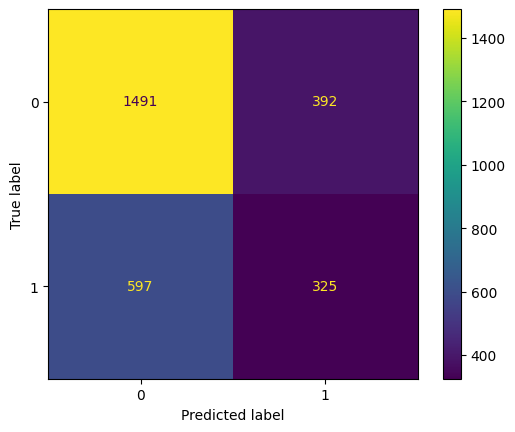

In [ ]:
from sklearn.metrics import accuracy_score
from sklearn.metrics import confusion_matrix, ConfusionMatrixDisplay
from sklearn.metrics import confusion_matrix

test = data_validation_labeled.drop(columns='label')
test_labels = data_validation_labeled.label
best_model = opt.best_estimator_
pred_y_test = best_model.predict(test)

print(f'Accuracy Score is {accuracy_score(test_labels,pred_y_test)}')
cm = confusion_matrix(test_labels, pred_y_test)
disp = ConfusionMatrixDisplay(confusion_matrix=cm)
disp.plot();

In [ ]:
cm = pd.DataFrame(cm, columns=['Predicted Negative', 'Predicted Positive'], index=['Actual Negative', 'Actual Positive'])

In [ ]:
from sklearn.metrics import classification_report
print(classification_report(test_labels, pred_y_test))

              precision    recall  f1-score   support

           0       0.71      0.79      0.75      1883
           1       0.45      0.35      0.40       922

    accuracy                           0.65      2805
   macro avg       0.58      0.57      0.57      2805
weighted avg       0.63      0.65      0.63      2805



In [ ]:
from sklearn.inspection import partial_dependence
numerics = ['int16', 'int32', 'int64', 'float16', 'float32', 'float64']
numeric_features = data_train_test.select_dtypes(include=numerics).columns.tolist()
categorical_features = data_train_test.columns.drop(numeric_features)
features = data_train_test.columns.tolist()[0]

pdp = partial_dependence(opt, data_train_test, features = [data_train_test.columns.tolist().index(features)],
                        feature_names=data_train_test.columns.tolist(),categorical_features=categorical_features)


In [ ]:
opt.best_estimator_

Pipeline(steps=[('preprocessor',
                 ColumnTransformer(transformers=[('num',
                                                  Pipeline(steps=[('scaler',
                                                                   StandardScaler())]),
                                                  ['dns_interlog_time_q1',
                                                   'dns_interlog_time_q2',
                                                   'dns_interlog_time_q3',
                                                   'dns_interlog_time_q4',
                                                   'dns_interlog_time_q5',
                                                   'ssl_interlog_time_q1',
                                                   'ssl_interlog_time_q2',
                                                   'ssl_interlog_time_q3',
                                                   'ssl_interlog_time_q4',
                                                   'ssl_interlog_time_q5',
                                                   'h...
                               feature_types=None, gamma=None, grow_policy=None,
                               importance_type=None,
                               interaction_constraints=None, learning_rate=0.1,
                               max_bin=None, max_cat_threshold=None,
                               max_cat_to_onehot=None, max_delta_step=None,
                               max_depth=2, max_leaves=None, min_child_weight=1,
                               missing=nan, monotone_constraints=None,
                               multi_strategy=None, n_estimators=75,
                               n_jobs=None, num_parallel_tree=None,
                               random_state=None, ...))])

In [ ]:
pdp['average']

array([[0.48360616, 0.48360616, 0.48360616, 0.48360616, 0.48360616,
        0.48360616, 0.46565068, 0.40676302, 0.37013802, 0.37013802,
        0.37013802, 0.37013802, 0.37013802, 0.37013802, 0.19749595,
        0.19749595, 0.19749595, 0.19749595, 0.19749595, 0.19749595,
        0.06236086, 0.06236086, 0.06236086, 0.06236086, 0.06236086,
        0.06236086, 0.06236086, 0.06236086, 0.06236086, 0.06236086,
        0.05391003, 0.05391003, 0.05391003, 0.05391003, 0.05391003,
        0.05391003, 0.05391003, 0.05391003, 0.05391003, 0.05391003,
        0.05391003, 0.05391003, 0.05391003, 0.05391003, 0.05391003,
        0.05391003, 0.05391003, 0.05391003, 0.05391003, 0.05391003,
        0.05391003, 0.05391003, 0.05391003, 0.05391003, 0.05391003,
        0.05391003, 0.05391003, 0.05391003, 0.05391003, 0.05391003,
        0.05391003, 0.05391003, 0.05391003, 0.05391003, 0.05391003,
        0.05391003, 0.05391003, 0.05391003, 0.05391003, 0.05391003,
        0.05391003, 0.05391003, 0.05391003, 0.05

In [ ]:
pdp

{'grid_values': [array([  0.        ,   4.51515152,   9.03030303,  13.54545455,
          18.06060606,  22.57575758,  27.09090909,  31.60606061,
          36.12121212,  40.63636364,  45.15151515,  49.66666667,
          54.18181818,  58.6969697 ,  63.21212121,  67.72727273,
          72.24242424,  76.75757576,  81.27272727,  85.78787879,
          90.3030303 ,  94.81818182,  99.33333333, 103.84848485,
         108.36363636, 112.87878788, 117.39393939, 121.90909091,
         126.42424242, 130.93939394, 135.45454545, 139.96969697,
         144.48484848, 149.        , 153.51515152, 158.03030303,
         162.54545455, 167.06060606, 171.57575758, 176.09090909,
         180.60606061, 185.12121212, 189.63636364, 194.15151515,
         198.66666667, 203.18181818, 207.6969697 , 212.21212121,
         216.72727273, 221.24242424, 225.75757576, 230.27272727,
         234.78787879, 239.3030303 , 243.81818182, 248.33333333,
         252.84848485, 257.36363636, 261.87878788, 266.39393939,
         2

In [ ]:
classification_report = pd.DataFrame(classification_report(test_labels, pred_y_test,output_dict=True)).transpose()

## Proxy Model creation for PDP-ALE and Counterfactual Explanations

In [ ]:
param_grid = {'Model__max_depth': (2, 4, 6, 10),
                                'Model__min_child_weight': (1, 3),
                                'Model__learning_rate': [0.001, 0.01, 0.1],
                                'Model__n_estimators': (25, 50, 75 , 100),
                                "preprocessor__num__scaler": [StandardScaler(), MinMaxScaler(),RobustScaler()]}

In [ ]:
#     # proxy model for PDP-ALE
# surrogate_model_accuracy = proxy_model(opt.param_grid,opt,'accuracy','XGBoostRegressor')


In [ ]:
missclassified = pd.concat([test, test_labels.rename('GroundTruth')], axis=1).reset_index(drop=True)
missclassified['Predicted'] = pred_y_test
missclassified['Label'] = (missclassified['GroundTruth'] != missclassified['Predicted']).astype(int)
missclassified[missclassified['Label']==1]

,dns_interlog_time_q1,dns_interlog_time_q2,dns_interlog_time_q3,dns_interlog_time_q4,dns_interlog_time_q5,ssl_interlog_time_q1,ssl_interlog_time_q2,ssl_interlog_time_q3,ssl_interlog_time_q4,ssl_interlog_time_q5,...,smtp_in_hazardous_extensions,non_working_days_dns,non_working_days_http,non_working_days_ssl,non_working_hours_dns,non_working_hours_http,non_working_hours_ssl,GroundTruth,Predicted,Label
2,22.0,0.0,0.0,0.0,0.0,61.0,1.0,0.0,0.0,0.0,...,0.0,0.0,0.0,0.0,0.333333,0.333333,0.333333,0,1,1
4,4.0,0.0,0.0,0.0,0.0,127.0,1.0,0.0,0.0,0.0,...,0.0,0.0,0.0,0.0,0.166667,0.166667,0.166667,0,1,1
5,0.0,0.0,0.0,0.0,0.0,97.0,1.0,0.0,0.0,0.0,...,0.0,0.0,0.0,0.0,0.000000,0.000000,0.000000,0,1,1
9,21.0,0.0,0.0,0.0,0.0,46.0,1.0,0.0,0.0,0.0,...,0.0,0.0,0.0,0.0,0.000000,0.000000,0.000000,0,1,1
10,0.0,0.0,0.0,0.0,0.0,52.0,1.0,0.0,0.0,0.0,...,0.0,0.0,0.0,0.0,0.000000,0.000000,0.000000,0,1,1
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
2800,0.0,0.0,0.0,0.0,0.0,12.0,0.0,0.0,0.0,0.0,...,0.0,0.0,0.0,0.0,0.000000,0.000000,0.000000,1,0,1
2801,0.0,0.0,0.0,0.0,0.0,12.0,0.0,0.0,0.0,0.0,...,0.0,0.0,0.0,0.0,0.000000,0.000000,0.000000,1,0,1
2802,31.0,0.0,0.0,0.0,0.0,24.0,1.0,0.0,0.0,0.0,...,0.0,0.0,0.0,0.0,0.000000,0.000000,0.000000,1,0,1
2803,38.0,0.0,0.0,0.0,0.0,56.0,1.0,0.0,0.0,0.0,...,0.0,0.0,0.0,0.0,0.000000,0.000000,0.000000,1,0,1


In [ ]:
missclassified[missclassified['Label']==1].drop(columns='Label').to_csv('misclassified_instances.csv')

In [ ]:
missclassified[missclassified['Label']==1].drop(columns='Label')

,dns_interlog_time_q1,dns_interlog_time_q2,dns_interlog_time_q3,dns_interlog_time_q4,dns_interlog_time_q5,ssl_interlog_time_q1,ssl_interlog_time_q2,ssl_interlog_time_q3,ssl_interlog_time_q4,ssl_interlog_time_q5,...,smtp_in_files,smtp_in_hazardous_extensions,non_working_days_dns,non_working_days_http,non_working_days_ssl,non_working_hours_dns,non_working_hours_http,non_working_hours_ssl,GroundTruth,Predicted
2,22.0,0.0,0.0,0.0,0.0,61.0,1.0,0.0,0.0,0.0,...,0.0,0.0,0.0,0.0,0.0,0.333333,0.333333,0.333333,0,1
4,4.0,0.0,0.0,0.0,0.0,127.0,1.0,0.0,0.0,0.0,...,0.0,0.0,0.0,0.0,0.0,0.166667,0.166667,0.166667,0,1
5,0.0,0.0,0.0,0.0,0.0,97.0,1.0,0.0,0.0,0.0,...,0.0,0.0,0.0,0.0,0.0,0.000000,0.000000,0.000000,0,1
9,21.0,0.0,0.0,0.0,0.0,46.0,1.0,0.0,0.0,0.0,...,0.0,0.0,0.0,0.0,0.0,0.000000,0.000000,0.000000,0,1
10,0.0,0.0,0.0,0.0,0.0,52.0,1.0,0.0,0.0,0.0,...,0.0,0.0,0.0,0.0,0.0,0.000000,0.000000,0.000000,0,1
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
2800,0.0,0.0,0.0,0.0,0.0,12.0,0.0,0.0,0.0,0.0,...,0.0,0.0,0.0,0.0,0.0,0.000000,0.000000,0.000000,1,0
2801,0.0,0.0,0.0,0.0,0.0,12.0,0.0,0.0,0.0,0.0,...,0.0,0.0,0.0,0.0,0.0,0.000000,0.000000,0.000000,1,0
2802,31.0,0.0,0.0,0.0,0.0,24.0,1.0,0.0,0.0,0.0,...,0.0,0.0,0.0,0.0,0.0,0.000000,0.000000,0.000000,1,0
2803,38.0,0.0,0.0,0.0,0.0,56.0,1.0,0.0,0.0,0.0,...,0.0,0.0,0.0,0.0,0.0,0.000000,0.000000,0.000000,1,0


In [ ]:
missclassified_instances = pd.read_csv('Real_I2Cat_missclassified_instances.csv',index_col=0)
# misclassified_instance = missclassified.drop(columns=['GroundTruth','Label']).loc[5]
# train = data_train_test.drop(columns='label')
# train_labels = data_train_test.label
# #proxy_model and dataset for counterfactual explanations
# proxy_model , proxy_dataset = instance_proxy(train,train_labels,opt, misclassified_instance,hyperparameters)

In [ ]:
query = pd.DataFrame.from_dict(opt.best_params_,orient='index').T


## Create gRPC Client

### Run `python xai_server.py` command on terminal in order to start server

### Compute PDP 1D Plots via gRPC

In [ ]:
# import grpc
# import xai_service_pb2
# import xai_service_pb2_grpc
# with grpc.insecure_channel('localhost:50051') as channel:
#     stub = xai_service_pb2_grpc.ExplanationsStub(channel)
#     k = stub.GetExplanation(xai_service_pb2.ExplanationsRequest(explanation_type='hyperparameterExplanation',explanation_method='pdp',model=['I2Cat_Phising_model'],feature1="Model__min_child_weight"))


In [ ]:
opt.param_grid

{'Model__max_depth': (2, 4, 6, 10),
 'Model__min_child_weight': (1, 3),
 'Model__learning_rate': [0.001, 0.01, 0.1],
 'Model__n_estimators': (25, 50, 75, 100),
 'preprocessor__num__scaler': [StandardScaler(),
  MinMaxScaler(),
  RobustScaler()]}

### Compute PDP 2D Plots via gRPC

In [ ]:
import json
from collections import defaultdict

# Example input JSON
model_configs = {
    "model_config_1": {
        "hyperparameter": {
            "Model__max_depth": {"values": "4", "type": "numeric"},
            "Model__min_child_weight": {"values": "1", "type": "numeric"},
            "Model__learning_rate": {"values": "0.01", "type": "numeric"},
            "Model__n_estimators": {"values": "50", "type": "numeric"},
            "preprocessor__num__scaler": {"values": "StandardScaler", "type": "categorical"}
        }
    },
    "model_config_2": {
        "hyperparameter": {
            "Model__max_depth": {"values": "6", "type": "numeric"},
            "Model__min_child_weight": {"values": "3", "type": "numeric"},
            "Model__learning_rate": {"values": "0.1", "type": "numeric"},
            "Model__n_estimators": {"values": "100", "type": "numeric"},
            "preprocessor__num__scaler": {"values": "MinMaxScaler", "type": "categorical"}
        }
    },
    "model_config_3": {
        "hyperparameter": {
            "Model__max_depth": {"values": "2", "type": "numeric"},
            "Model__min_child_weight": {"values": "1", "type": "numeric"},
            "Model__learning_rate": {"values": "0.001", "type": "numeric"},
            "Model__n_estimators": {"values": "25", "type": "numeric"},
            "preprocessor__num__scaler": {"values": "RobustScaler", "type": "categorical"}
        }
    },
    "model_config_4": {
        "hyperparameter": {
            "Model__max_depth": {"values": "8", "type": "numeric"},
            "Model__min_child_weight": {"values": "2", "type": "numeric"},
            "Model__learning_rate": {"values": "0.05", "type": "numeric"},
            "Model__n_estimators": {"values": "75", "type": "numeric"},
            "preprocessor__num__scaler": {"values": "StandardScaler", "type": "categorical"}
        }
    },
    "model_config_5": {
        "hyperparameter": {
            "Model__max_depth": {"values": "5", "type": "numeric"},
            "Model__min_child_weight": {"values": "2", "type": "numeric"},
            "Model__learning_rate": {"values": "0.02", "type": "numeric"},
            "Model__n_estimators": {"values": "50", "type": "numeric"},
            "preprocessor__num__scaler": {"values": "MinMaxScaler", "type": "categorical"}
        }
    },
    "model_config_6": {
        "hyperparameter": {
            "Model__max_depth": {"values": "7", "type": "numeric"},
            "Model__min_child_weight": {"values": "3", "type": "numeric"},
            "Model__learning_rate": {"values": "0.005", "type": "numeric"},
            "Model__n_estimators": {"values": "150", "type": "numeric"},
            "preprocessor__num__scaler": {"values": "RobustScaler", "type": "categorical"}
        }
    },
    "model_config_7": {
        "hyperparameter": {
            "Model__max_depth": {"values": "3", "type": "numeric"},
            "Model__min_child_weight": {"values": "2", "type": "numeric"},
            "Model__learning_rate": {"values": "0.03", "type": "numeric"},
            "Model__n_estimators": {"values": "60", "type": "numeric"},
            "preprocessor__num__scaler": {"values": "StandardScaler", "type": "categorical"}
        }
    },
    "model_config_8": {
        "hyperparameter": {
            "Model__max_depth": {"values": "9", "type": "numeric"},
            "Model__min_child_weight": {"values": "4", "type": "numeric"},
            "Model__learning_rate": {"values": "0.07", "type": "numeric"},
            "Model__n_estimators": {"values": "125", "type": "numeric"},
            "preprocessor__num__scaler": {"values": "MinMaxScaler", "type": "categorical"}
        }
    },
    "model_config_9": {
        "hyperparameter": {
            "Model__max_depth": {"values": "10", "type": "numeric"},
            "Model__min_child_weight": {"values": "5", "type": "numeric"},
            "Model__learning_rate": {"values": "0.09", "type": "numeric"},
            "Model__n_estimators": {"values": "175", "type": "numeric"},
            "preprocessor__num__scaler": {"values": "RobustScaler", "type": "categorical"}
        }
    },
    "model_config_10": {
        "hyperparameter": {
            "Model__max_depth": {"values": "11", "type": "numeric"},
            "Model__min_child_weight": {"values": "1", "type": "numeric"},
            "Model__learning_rate": {"values": "0.04", "type": "numeric"},
            "Model__n_estimators": {"values": "200", "type": "numeric"},
            "preprocessor__num__scaler": {"values": "StandardScaler", "type": "categorical"}
        }
    }
}

x = create_hyperspace(model_configs)
df = create_hyper_df(model_configs)

In [ ]:
metrics = {
  "metrics": {
    "accuracy": {
      "value": [0.85, 0.87, 0.88, 0.89, 0.90, 0.86, 0.91, 0.84, 0.92, 0.88]
    }
  }
}

In [ ]:
for key,value in metrics.items():
    for key2,value2 in value.items():
        y = value2['value']
        

[0.85, 0.87, 0.88, 0.89, 0.9, 0.86, 0.91, 0.84, 0.92, 0.88]


In [ ]:
df

,Model__max_depth,Model__min_child_weight,Model__learning_rate,Model__n_estimators,preprocessor__num__scaler,accuracy
0,4,1,0.010,50,StandardScaler,0.85
1,6,3,0.100,100,MinMaxScaler,0.87
2,2,1,0.001,25,RobustScaler,0.88
3,8,2,0.050,75,StandardScaler,0.89
4,5,2,0.020,50,MinMaxScaler,0.90
5,7,3,0.005,150,RobustScaler,0.86
6,3,2,0.030,60,StandardScaler,0.91
7,9,4,0.070,125,MinMaxScaler,0.84
8,10,5,0.090,175,RobustScaler,0.92
9,11,1,0.040,200,StandardScaler,0.88


In [ ]:
param_grid = transform_grid(x)
param_space, name = dimensions_aslists(param_grid)
space = Space(param_space)

In [ ]:
param_grid

{'Model__max_depth': Integer(low=2, high=11, prior='uniform', transform='normalize'),
 'Model__min_child_weight': Integer(low=1, high=5, prior='uniform', transform='normalize'),
 'Model__learning_rate': Real(low=0.001, high=0.1, prior='uniform', transform='normalize'),
 'Model__n_estimators': Integer(low=25, high=200, prior='uniform', transform='normalize'),
 'preprocessor__num__scaler': ['StandardScaler',
  'MinMaxScaler',
  'RobustScaler']}

In [ ]:
space.rvs(n_samples=1000)[0]

[10, 2, 0.0439981246517768, 147, 'RobustScaler']

In [ ]:
transform_grid(x)

{'Model__max_depth': Integer(low=2, high=6, prior='uniform', transform='normalize'),
 'Model__min_child_weight': Integer(low=1, high=3, prior='uniform', transform='normalize'),
 'Model__learning_rate': Real(low=0.001, high=0.1, prior='uniform', transform='normalize'),
 'Model__n_estimators': Integer(low=25, high=100, prior='uniform', transform='normalize'),
 'preprocessor__num__scaler': ['StandardScaler',
  'RobustScaler',
  'MinMaxScaler']}

In [ ]:
param = transform_grid_plt(opt.param_grid)

NameError: name 'opt' is not defined

In [ ]:
param_grid = transform_grid(param)
_, name = dimensions_aslists(param_grid)

In [ ]:
hyperparameters = opt.cv_results_['params']
samples = transform_samples(hyperparameters,name)

In [ ]:
samples

[[2, 1, 0.001, 25, 'StandardScaler()'],
 [2, 1, 0.001, 25, 'MinMaxScaler()'],
 [2, 1, 0.001, 25, 'RobustScaler()'],
 [2, 1, 0.001, 50, 'StandardScaler()'],
 [2, 1, 0.001, 50, 'MinMaxScaler()'],
 [2, 1, 0.001, 50, 'RobustScaler()'],
 [2, 1, 0.001, 75, 'StandardScaler()'],
 [2, 1, 0.001, 75, 'MinMaxScaler()'],
 [2, 1, 0.001, 75, 'RobustScaler()'],
 [2, 1, 0.001, 100, 'StandardScaler()'],
 [2, 1, 0.001, 100, 'MinMaxScaler()'],
 [2, 1, 0.001, 100, 'RobustScaler()'],
 [2, 3, 0.001, 25, 'StandardScaler()'],
 [2, 3, 0.001, 25, 'MinMaxScaler()'],
 [2, 3, 0.001, 25, 'RobustScaler()'],
 [2, 3, 0.001, 50, 'StandardScaler()'],
 [2, 3, 0.001, 50, 'MinMaxScaler()'],
 [2, 3, 0.001, 50, 'RobustScaler()'],
 [2, 3, 0.001, 75, 'StandardScaler()'],
 [2, 3, 0.001, 75, 'MinMaxScaler()'],
 [2, 3, 0.001, 75, 'RobustScaler()'],
 [2, 3, 0.001, 100, 'StandardScaler()'],
 [2, 3, 0.001, 100, 'MinMaxScaler()'],
 [2, 3, 0.001, 100, 'RobustScaler()'],
 [4, 1, 0.001, 25, 'StandardScaler()'],
 [4, 1, 0.001, 25, 'MinMax

In [ ]:
import grpc
import xai_service_pb2
import xai_service_pb2_grpc
with grpc.insecure_channel('localhost:50051') as channel:
    stub = xai_service_pb2_grpc.ExplanationsStub(channel)
    k = stub.GetExplanation(xai_service_pb2.ExplanationsRequest(explanation_type='hyperparameterExplanation',explanation_method='2dpdp',model='I2Cat_Phising_model',feature1='Model__min_child_weight',feature2='Model__max_depth'))

### Compute ALE Plots via gRPC

In [ ]:
def create_hyperparameter_protobuf(model_configs):
    hyper_configs = {}
    
    for model_name, config in model_configs.items():
        hyperparameter = xai_service_pb2.hyperparameters()
        
        for param_name, param_details in config["hyperparameter"].items():
            hyperparameter_list = xai_service_pb2.hyperparameters.HyperparameterList()
            hyperparameter_list.values = param_details["values"]
            hyperparameter_list.type = param_details["type"]
            
            # Add the hyperparameter to the model config
            hyper_configs[model_name] = hyperparameter
    
    return hyper_configs

create_hyperparameter_protobuf(model_configs)

{'model_config_1': ,
 'model_config_2': ,
 'model_config_3': ,
 'model_config_4': ,
 'model_config_5': ,
 'model_config_6': ,
 'model_config_7': ,
 'model_config_8': ,
 'model_config_9': ,
 'model_config_10': }

In [ ]:
import grpc
import xai_service_pb2
import xai_service_pb2_grpc
with grpc.insecure_channel('localhost:50051') as channel:
    stub = xai_service_pb2_grpc.ExplanationsStub(channel)
    k = stub.GetExplanation(xai_service_pb2.ExplanationsRequest(explanation_type='hyperparameterExplanation',explanation_method='pdp',
                                                                hyper_configs = model_configs,
                                                                metrics = metrics,
                                                                feature1='Model__min_child_weight'))


TypeError: Parameter to CopyFrom() must be instance of same class: expected <class 'xai_service_pb2.hyperparameters'> got <class 'dict'>.

### Counterfactual Explanations via gRPC

In [ ]:
missclassified_instances.reset_index()

,index,dns_interlog_time_q1,dns_interlog_time_q2,dns_interlog_time_q3,dns_interlog_time_q4,dns_interlog_time_q5,ssl_interlog_time_q1,ssl_interlog_time_q2,ssl_interlog_time_q3,ssl_interlog_time_q4,...,smtp_in_hazardous_extensions,non_working_days_dns,non_working_days_http,non_working_days_ssl,non_working_hours_dns,non_working_hours_http,non_working_hours_ssl,label,prediction,id
0,0,18.0,0.0,0.0,0.0,0.0,10.0,0.0,0.0,0.0,...,0.0,0.0,0.0,0.0,0.166667,0.166667,0.166667,0,0,0
1,0,22.0,0.0,0.0,0.0,0.0,40.0,0.0,0.0,0.0,...,0.0,0.0,0.0,0.0,0.333333,0.333333,0.333333,0,0,0
2,0,22.0,0.0,0.0,0.0,0.0,61.0,1.0,0.0,0.0,...,0.0,0.0,0.0,0.0,0.333333,0.333333,0.333333,0,0,0
3,0,22.0,0.0,0.0,0.0,0.0,137.0,1.0,0.0,0.0,...,0.0,0.0,0.0,0.0,0.333333,0.333333,0.333333,0,0,0
4,0,4.0,0.0,0.0,0.0,0.0,127.0,1.0,0.0,0.0,...,0.0,0.0,0.0,0.0,0.166667,0.166667,0.166667,0,0,0
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
807835,0,0.0,0.0,0.0,0.0,0.0,12.0,0.0,0.0,0.0,...,0.0,0.0,0.0,0.0,0.000000,0.000000,0.000000,1,1,287
807836,0,0.0,0.0,0.0,0.0,0.0,12.0,0.0,0.0,0.0,...,0.0,0.0,0.0,0.0,0.000000,0.000000,0.000000,1,1,287
807837,0,31.0,0.0,0.0,0.0,0.0,24.0,1.0,0.0,0.0,...,0.0,0.0,0.0,0.0,0.000000,0.000000,0.000000,1,0,287
807838,0,38.0,0.0,0.0,0.0,0.0,56.0,1.0,0.0,0.0,...,0.0,0.0,0.0,0.0,0.000000,0.000000,0.000000,1,1,287


In [ ]:
str(missclassified_instances.reset_index(drop=True).loc[807839].to_dict())

"{'dns_interlog_time_q1': 7.0, 'dns_interlog_time_q2': 0.0, 'dns_interlog_time_q3': 0.0, 'dns_interlog_time_q4': 0.0, 'dns_interlog_time_q5': 0.0, 'ssl_interlog_time_q1': 32.0, 'ssl_interlog_time_q2': 0.0, 'ssl_interlog_time_q3': 0.0, 'ssl_interlog_time_q4': 0.0, 'ssl_interlog_time_q5': 0.0, 'http_interlog_time_q1': 15.0, 'http_interlog_time_q2': 0.0, 'http_interlog_time_q3': 0.0, 'http_interlog_time_q4': 0.0, 'http_interlog_time_q5': 0.0, 'mean_interlog_time_dns_interlog_time': 0.7719999999999999, 'std_interlog_time_dns_interlog_time': 0.0, 'mean_interlog_time_ssl_interlog_time': 5.39884375, 'std_interlog_time_ssl_interlog_time': 0.0, 'mean_interlog_time_http_interlog_time': 6.069000000000001, 'std_interlog_time_http_interlog_time': 0.0, 'dns_protocol_tcp_ratio': 0.0, 'dns_common_tcp_ports_ratio': 0.0, 'dns_common_udp_ports_ratio': 1.0, 'dns_rcode_error_ratio': 0.0, 'dns_rcode_nxdomain_ratio': 0.0, 'dns_rcode_noauth_ratio': 0.0, 'dns_rcode_refused_ratio': 0.0, 'dns_rcode_notzone_ratio

In [ ]:
import grpc
import xai_service_pb2
import xai_service_pb2_grpc
with grpc.insecure_channel('localhost:50051') as channel:
    stub = xai_service_pb2_grpc.ExplanationsStub(channel)
    k = stub.GetExplanation(xai_service_pb2.ExplanationsRequest(explanation_type='hyperparameterExplanation',explanation_method='counterfactuals',model='I2Cat_Phising_model',model_id=1,query=str(missclassified_instances.reset_index(drop=True).drop(columns = ['label','prediction','id']).loc[806913].to_dict())))


## Model Explainability

### PDPlots and 2D PDPlots via gRPC

In [ ]:
# import grpc
# import xai_service_pb2
# import xai_service_pb2_grpc
# with grpc.insecure_channel('localhost:50051') as channel:
#     stub = xai_service_pb2_grpc.ExplanationsStub(channel)
#     k = stub.GetExplanation(xai_service_pb2.ExplanationsRequest(explanation_type='featureExplanation',explanation_method='ale',
#                                                   model = 'I2Cat_Phising_model',model_id=209, feature1='dns_interlog_time_q2'))

In [ ]:
import grpc
import xai_service_pb2
import xai_service_pb2_grpc
with grpc.insecure_channel('localhost:50051') as channel:
    stub = xai_service_pb2_grpc.ExplanationsStub(channel)
    k = stub.GetExplanation(xai_service_pb2.ExplanationsRequest(explanation_type='featureExplanation',explanation_method='ale',
                                                  model = ["metadata/proxy_data_models/cf_trained_models.pkl"],data='metadata/datasets/phising.csv',target_column='label',train_index=train_index,test_index=test_index))

In [ ]:
with grpc.insecure_channel('localhost:50051') as channel:
    stub = xai_service_pb2_grpc.ExplanationsStub(channel)
    k = stub.GetFeatureImportance(xai_service_pb2.FeatureImportanceRequest(data='metadata/datasets/phising.csv',target_column='label',test_index=test_index,model = ["metadata/proxy_data_models/cf_trained_models.pkl"]))

## CounterfactualsExplanations via gRPC

In [ ]:
import grpc
import xai_service_pb2
import xai_service_pb2_grpc

with grpc.insecure_channel('localhost:50051') as channel:
    stub = xai_service_pb2_grpc.ExplanationsStub(channel)
    k = stub.GetExplanation(xai_service_pb2.ExplanationsRequest(explanation_type='featureExplanation',explanation_method='global_counterfactuals',
                                                                model = ["metadata/proxy_data_models/cf_trained_models.pkl"],data='metadata/datasets/phising.csv',
                                                                target_column='label',train_index=train_index,test_index=test_index,
                                                                gcf_size=3,cf_generator="Dice",cluster_action_choice_algo = "max-eff"))
    
    

In [ ]:
with grpc.insecure_channel('localhost:50051') as channel:
    stub = xai_service_pb2_grpc.ExplanationsStub(channel)
    k = stub.ApplyAffectedActions(xai_service_pb2.ApplyAffectedActionsRequest())

In [ ]:
import grpc
import xai_service_pb2
import xai_service_pb2_grpc
with grpc.insecure_channel('localhost:50051') as channel:
    stub = xai_service_pb2_grpc.ExplanationsStub(channel)
    k = stub.GetExplanation(xai_service_pb2.ExplanationsRequest(explanation_type='featureExplanation',explanation_method='counterfactuals',query=str(missclassified_instances.reset_index(drop=True).loc[806913].to_dict()),
                                                                model = ["metadata/proxy_data_models/cf_trained_models.pkl"],data='metadata/datasets/phising.csv',
                                                                target_column='label',train_index=train_index,test_index=test_index,))


### ALE plots via gRPC

In [ ]:
import grpc
import xai_service_pb2
import xai_service_pb2_grpc
with grpc.insecure_channel('localhost:50051') as channel:
    stub = xai_service_pb2_grpc.ExplanationsStub(channel)
    k = stub.GetExplanation(xai_service_pb2.ExplanationsRequest(explanation_type='featureExplanation',explanation_method='ale',
                                                                model = ["metadata/proxy_data_models/cf_trained_models.pkl"],data='metadata/datasets/phising.csv',
                                                                train_index=train_index,test_index=test_index,target_column = 'label'))

In [ ]:
import grpc
import xai_service_pb2
import xai_service_pb2_grpc
with grpc.insecure_channel('localhost:50051') as channel:
    stub = xai_service_pb2_grpc.ExplanationsStub(channel)
    k = stub.GetExplanation(xai_service_pb2.ExplanationsRequest(explanation_type='featureExplanation',explanation_method='2dpdp',
                                                                model = ["metadata/proxy_data_models/cf_trained_models.pkl"],data='metadata/datasets/phising.csv',
                                                                train_index=train_index,test_index=test_index,target_column = 'label'))

### Prototypes via gRPC

In [ ]:
from modules.lib import _load_model
model,_ = _load_model('metadata/proxy_data_models/I2Cat_workflow1.pkl')

Sklearn model detected
Sklearn model loaded


In [ ]:
data_validation_labeled['prediction'] = model.predict(data_validation_labeled)
data_validation_labeled['id'] = 0

In [ ]:
data_validation_labeled.reset_index(drop=True,inplace=True)

In [ ]:
data_validation_labeled

,dns_interlog_time_q1,dns_interlog_time_q2,dns_interlog_time_q3,dns_interlog_time_q4,dns_interlog_time_q5,ssl_interlog_time_q1,ssl_interlog_time_q2,ssl_interlog_time_q3,ssl_interlog_time_q4,ssl_interlog_time_q5,...,smtp_in_hazardous_extensions,non_working_days_dns,non_working_days_http,non_working_days_ssl,non_working_hours_dns,non_working_hours_http,non_working_hours_ssl,label,prediction,id
0,18.0,0.0,0.0,0.0,0.0,10.0,0.0,0.0,0.0,0.0,...,0.0,0.0,0.0,0.0,0.166667,0.166667,0.166667,0,0,0
1,22.0,0.0,0.0,0.0,0.0,40.0,0.0,0.0,0.0,0.0,...,0.0,0.0,0.0,0.0,0.333333,0.333333,0.333333,0,0,0
2,22.0,0.0,0.0,0.0,0.0,61.0,1.0,0.0,0.0,0.0,...,0.0,0.0,0.0,0.0,0.333333,0.333333,0.333333,0,1,0
3,22.0,0.0,0.0,0.0,0.0,137.0,1.0,0.0,0.0,0.0,...,0.0,0.0,0.0,0.0,0.333333,0.333333,0.333333,0,0,0
4,4.0,0.0,0.0,0.0,0.0,127.0,1.0,0.0,0.0,0.0,...,0.0,0.0,0.0,0.0,0.166667,0.166667,0.166667,0,0,0
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
2800,0.0,0.0,0.0,0.0,0.0,12.0,0.0,0.0,0.0,0.0,...,0.0,0.0,0.0,0.0,0.000000,0.000000,0.000000,1,1,0
2801,0.0,0.0,0.0,0.0,0.0,12.0,0.0,0.0,0.0,0.0,...,0.0,0.0,0.0,0.0,0.000000,0.000000,0.000000,1,1,0
2802,31.0,0.0,0.0,0.0,0.0,24.0,1.0,0.0,0.0,0.0,...,0.0,0.0,0.0,0.0,0.000000,0.000000,0.000000,1,0,0
2803,38.0,0.0,0.0,0.0,0.0,56.0,1.0,0.0,0.0,0.0,...,0.0,0.0,0.0,0.0,0.000000,0.000000,0.000000,1,0,0


In [ ]:
import grpc
import xai_service_pb2
import xai_service_pb2_grpc

with grpc.insecure_channel('localhost:50051') as channel:
    stub = xai_service_pb2_grpc.ExplanationsStub(channel)
    k = stub.GetExplanation(xai_service_pb2.ExplanationsRequest(explanation_type='featureExplanation',explanation_method='prototypes',query=str(data_validation_labeled.reset_index(drop=True).loc[2802].to_dict()),model = ["metadata/proxy_data_models/I2Cat_workflow1.pkl"],
                                                                data='metadata/datasets/phising.csv',target_column='label',
                                                                train_index=train_index))

In [ ]:
missclassified_instances.reset_index(drop=True).loc[47]

dns_interlog_time_q1      1.0
dns_interlog_time_q2      0.0
dns_interlog_time_q3      0.0
dns_interlog_time_q4      0.0
dns_interlog_time_q5      0.0
                         ... 
non_working_hours_http    0.0
non_working_hours_ssl     0.0
label                     0.0
prediction                0.0
id                        0.0
Name: 47, Length: 84, dtype: float64

In [ ]:
str(missclassified_instances.reset_index(drop=True).loc[47].to_dict())

"{'dns_interlog_time_q1': 1.0, 'dns_interlog_time_q2': 0.0, 'dns_interlog_time_q3': 0.0, 'dns_interlog_time_q4': 0.0, 'dns_interlog_time_q5': 0.0, 'ssl_interlog_time_q1': 54.0, 'ssl_interlog_time_q2': 4.0, 'ssl_interlog_time_q3': 1.0, 'ssl_interlog_time_q4': 0.0, 'ssl_interlog_time_q5': 0.0, 'http_interlog_time_q1': 8.0, 'http_interlog_time_q2': 0.0, 'http_interlog_time_q3': 1.0, 'http_interlog_time_q4': 0.0, 'http_interlog_time_q5': 1.0, 'mean_interlog_time_dns_interlog_time': 1.014, 'std_interlog_time_dns_interlog_time': 0.0, 'mean_interlog_time_ssl_interlog_time': 29.916, 'std_interlog_time_ssl_interlog_time': 0.0, 'mean_interlog_time_http_interlog_time': 75.5297, 'std_interlog_time_http_interlog_time': 0.0, 'dns_protocol_tcp_ratio': 0.0, 'dns_common_tcp_ports_ratio': 0.0, 'dns_common_udp_ports_ratio': 1.0, 'dns_rcode_error_ratio': 0.0, 'dns_rcode_nxdomain_ratio': 0.0, 'dns_rcode_noauth_ratio': 0.0, 'dns_rcode_refused_ratio': 0.0, 'dns_rcode_notzone_ratio': 0.0, 'dns_authoritative_a